# Statistical Tests

We want to know whether the difference between averages for different HOLC grades is statistically significant. To do this we apply Student's t-test. This is designed to compare two different averages, so we compute the the significance between two HOLC grades at a time, giving a total of 3! tests.

The compares against the null hypothesis, which states there is not difference between the means. If the calculated t-value is greater than the t-value from the t-table (for your desired alpha), then the null hypothesis can be rejected. This implies that the differences between the populations did not happen by chance. 

We apply the equal variance independent T-Test. Assumptions of the test:

1. The data is normally distributed
2. The population variance in unknown, and the sample variances are approximately equal
3. The data leading to each mean are independent. *(There's no overlap in HOLC boundaries, so I think this holds.)*

## Data 

From each Landsat file, we have one value for the mean of meadians of HOLC A through HOLC D. The set of means forms the data sets used in the test. This means we have 113 data elements for every HOLC grade, since we have one value for every Landsat file. 

# Equal variance independent T-test

In [89]:
import os
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_DATA = DIR_PARENT + "/02-data"
DIR_STATS_AGG = DIR_DATA + "/summary_stats_agg"

# START FILE IMPORT
lst_stats = pd.read_csv(DIR_STATS_AGG + "/lst_mean_stats_combined.csv")
ndvi_stats = pd.read_csv(DIR_STATS_AGG + "/ndvi_mean_stats_combined.csv")

stat_choice = "median" # OPTIONS: "mean", "median", "min", "max", "stdev"

# Filter the LST data for NYC. This can be repeated for any of the 
# boroughs as well. 
lst_a = lst_stats[(lst_stats["holc_grade"]=="A") & \
                  (lst_stats["loc_year"]=="NYC")][stat_choice]
lst_b = lst_stats[(lst_stats["holc_grade"]=="B")& \
                  (lst_stats["loc_year"]=="NYC")][stat_choice]
lst_c = lst_stats[(lst_stats["holc_grade"]=="C")& \
                  (lst_stats["loc_year"]=="NYC")][stat_choice]
lst_d = lst_stats[(lst_stats["holc_grade"]=="D")& \
                  (lst_stats["loc_year"]=="NYC")][stat_choice]

## Assumption 1: Normal distribution of the data

Below we plot a histogram of the data used to compute the mean LST for each HOLC grade. We compute the mean and standard deviation, and overlay a Gaussian curve to visually test whether the data is normally distributed. 

Mean LST =  301.7414044051033
Stdev LST =  3.6494635969650293


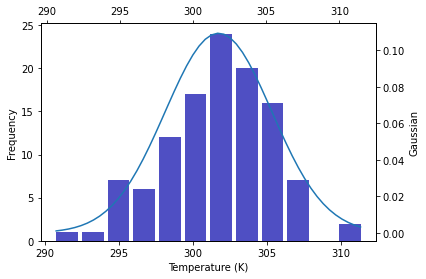

In [133]:
data_to_test = lst_c

#########################################################################
fig, ax = plt.subplots(1,1)

ax2 = ax.twinx()
ax3 = ax2.twiny()

ax.hist(x=data_to_test, bins='auto', 
        color='#0504aa', alpha=0.7, rwidth=0.85)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Frequency")

"""Make Gasssian plot"""
avg_data = np.mean(data_to_test)
std_data = np.std(data_to_test)
xgauss = np.linspace(np.min(data_to_test),np.max(data_to_test),50)
ygauss = [(1/(std_data*np.sqrt(2*np.pi)))*np.exp(-(x-avg_data)**2/(2*std_data**2)) for x in xgauss]

ax3.plot(xgauss, ygauss)
ax2.set_ylabel("Gaussian")

print("Mean LST = ", avg_data)
print("Stdev LST = ", std_data)

## Assumption 2: Variances are the same

Calculating the variance of each data set, we indeed find that they're about the same. 

In [79]:
print("Variance of HOLC A = ", np.var(lst_a))
print("Variance of HOLC B = ", np.var(lst_b))
print("Variance of HOLC C = ", np.var(lst_c))
print("Variance of HOLC D = ", np.var(lst_d))

Variance of HOLC A =  13.383139377746755
Variance of HOLC B =  12.678654170025101
Variance of HOLC C =  13.31858454557293
Variance of HOLC D =  13.550190683518561


## Compute t-values

Below we compute the t-values between pairs of HOLC grades. In this way, we test for independence of means between HOLC A and HOLC B, HOLC A and HOLC C, etc. 

We use `scipy`'s `ttest_ind` function. The documentation gives the following description of this function. 

    Calculate the T-test for the means of two independent samples of scores.

    This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

In [130]:
stat_df = pd.DataFrame(columns=["t-value","p-value"],
                      index=["ab","ac","ad","bc","bd","cd"])

stat_df.loc["ab"] = stats.ttest_ind(lst_a, lst_b)
stat_df.loc["ac"] = stats.ttest_ind(lst_a, lst_c)
stat_df.loc["ad"] = stats.ttest_ind(lst_a, lst_d)
stat_df.loc["bc"] = stats.ttest_ind(lst_b, lst_c)
stat_df.loc["bd"] = stats.ttest_ind(lst_b, lst_d)
stat_df.loc["cd"] = stats.ttest_ind(lst_c, lst_d)

"""Add a column for the degrees of freedom"""
dof = [len(lst_a)+len(lst_b)-2,
        len(lst_a)+len(lst_c)-2,
        len(lst_a)+len(lst_d)-2,
        len(lst_b)+len(lst_c)-2,
        len(lst_b)+len(lst_d)-2,
        len(lst_c)+len(lst_d)-2]
stat_df["degrees-of-freedom"] = dof

# Print the table
stat_df

,t-value,p-value,degrees-of-freedom
ab,-2.94452,0.00357552,224
ac,-4.78656,3.08106e-06,224
ad,-4.72085,4.13927e-06,224
bc,-1.9028,0.0583491,224
bd,-1.8487,0.0658187,224
cd,0.0451303,0.964044,224


We refer to the t-table, which can be found [here](https://www.brockport.edu/academics/tutoring/docs/students_t_distribution_table.pdf), to find the null-hypothesis t-value for 

- one-tail alpha level of 0.05
- 224 degrees of freedom

**The table predicts a value of $\approx 1.6$.** Almost all t-values we computed are greater than this, and we can be confident that those means are independent. Something strange seems to be happening with the `cd` combination. 